# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import f1_score

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hyperparameters

In [2]:
# random seed
SEED = 42
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# MNIST 数据集的均值和标准差
mnist_mean = (0.1307,)
mnist_std = (0.3081,)

# MNIST 数据集的转换
transform_mnist_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomCrop(28, padding=4),  # MNIST 图像大小为 28x28，所以不需要过大的 RandomCrop
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std),
])

transform_mnist_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std),
])

# 加载 MNIST 训练集
train_set = torchvision.datasets.MNIST(root='../data', train=True,
                                       download=True, transform=transform_mnist_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=2)

# 加载 MNIST 测试集
test_set = torchvision.datasets.MNIST(root='../data', train=False,
                                      download=True, transform=transform_mnist_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False, num_workers=2)

# 类别名称（MNIST 只有数字0到9）
class_names = [str(i) for i in range(10)]

### Model

In [5]:

# 定义基本的 ResNet 模块
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# 定义 ResNet-50 模型
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# 创建 ResNet-50 模型
def resnet50(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model

# 初始化 ResNet-50 模型
model = resnet50()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# 打印模型结构
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

### Optimizer

In [6]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return torch.mean(focal_loss)

In [8]:

criterion1 = nn.CrossEntropyLoss()


In [9]:
def train_batch(model, image, target, criterion):
    output = model(image)
    loss = criterion(output, target)
    return output, loss

In [10]:
def test_batch(model, image, target, criterion):
    output = model(image)
    loss = criterion(output, target)
    return output, loss

### Model Training

In [11]:
import os
import os.path as osp
import torch
import numpy as np
from sklearn.metrics import f1_score
import pandas as pd

    

# Define your constants here
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = 'models'  # Change this to your desired directory

# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Acc', 'Test Loss', 'Test Acc', 'F1 Score'])

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model 这里是修改train_batch1234的地方
        outputs, loss = train_batch(model, image, target, criterion1)
        _, preds = torch.max(outputs, 1)

        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # change learning rate
    scheduler.step()

    ##########################
    ### Testing
    ##########################
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()

        val_loss = 0.0
        val_corrects = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for batch_idx, (image, target) in enumerate(test_dataloader):

                image = image.to(device)
                target = target.to(device)

                # test model
                outputs, loss = test_batch(model, image, target, criterion1)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Calculate F1 Score
        f1 = f1_score(all_targets, all_preds, average='weighted')
        print(f'F1 Score: {f1:.4f}')

        results_df = pd.concat([
            results_df,
            pd.DataFrame({
                'Epoch': [epoch + 1],
                'Train Loss': [epoch_loss],
                'Train Acc': [epoch_acc.item()],
                'Test Loss': [val_loss],
                'Test Acc': [val_acc.item()],
                'F1 Score': [f1]
            })
        ], ignore_index=True)

        # save the model in the last epoch
        if (epoch + 1) == NUM_EPOCHS:
            state = {
                'state_dict': model.state_dict(),
                'acc': epoch_acc.item(),
                'epoch': (epoch + 1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))))

# Save the results DataFrame to a CSV file
results_df.to_csv('ass3_2_results.csv', index=False)


Epoch: 1/30 Train Loss: 0.0133 Acc: 0.4670
Begin test......
Test Loss: 0.0054 Acc: 0.7727
F1 Score: 0.7723
Epoch: 2/30 Train Loss: 0.0045 Acc: 0.8088
Begin test......
Test Loss: 0.0030 Acc: 0.8718
F1 Score: 0.8719
Epoch: 3/30 Train Loss: 0.0024 Acc: 0.9012
Begin test......
Test Loss: 0.0025 Acc: 0.8987
F1 Score: 0.8976
Epoch: 4/30 Train Loss: 0.0015 Acc: 0.9375
Begin test......
Test Loss: 0.0018 Acc: 0.9304
F1 Score: 0.9314
Epoch: 5/30 Train Loss: 0.0012 Acc: 0.9510
Begin test......
Test Loss: 0.0009 Acc: 0.9638
F1 Score: 0.9637
Epoch: 6/30 Train Loss: 0.0009 Acc: 0.9639
Begin test......
Test Loss: 0.0006 Acc: 0.9756
F1 Score: 0.9756
Epoch: 7/30 Train Loss: 0.0008 Acc: 0.9672
Begin test......
Test Loss: 0.0005 Acc: 0.9780
F1 Score: 0.9780
Epoch: 8/30 Train Loss: 0.0007 Acc: 0.9695
Begin test......
Test Loss: 0.0006 Acc: 0.9740
F1 Score: 0.9740
Epoch: 9/30 Train Loss: 0.0007 Acc: 0.9717
Begin test......
Test Loss: 0.0005 Acc: 0.9781
F1 Score: 0.9781
Epoch: 10/30 Train Loss: 0.0007 Acc: 

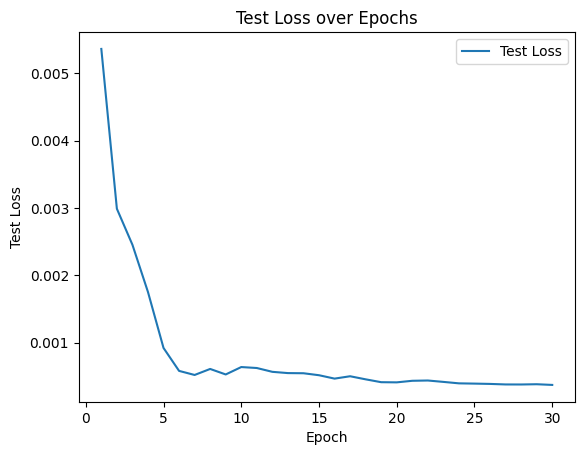

In [12]:
plt.plot(results_df['Epoch'], results_df['Test Loss'], label='Test Loss')
plt.title('Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.legend()
plt.show()

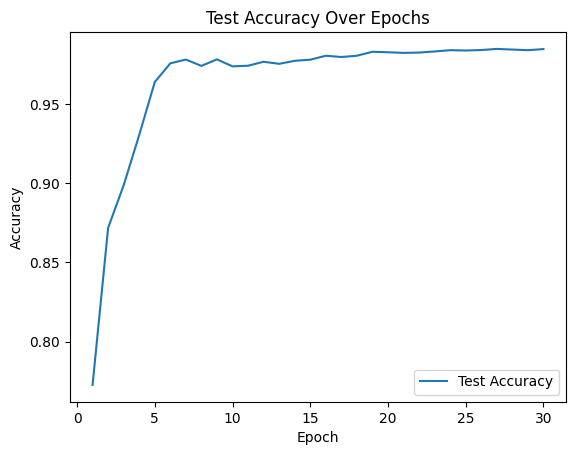

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 从CSV文件中读取数据
results_df = pd.read_csv('ass3_2_results.csv')

# 绘制准确率曲线
plt.plot(results_df['Epoch'], results_df['Test Acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.legend()
plt.show()

NameError: name 'model_inference' is not defined